Do not delete this cell. It defines custom LaTeX commands.
$$
\newcommand{\xb}{\boldsymbol{x}}
\newcommand{\wb}{\boldsymbol{w}}
\newcommand{\pb}{\boldsymbol{p}}
\newcommand{\1}{\mathbb{1}}
$$

# Logistic Regression and MLPs with PyTorch

Here you will continue to classify images as either 4s or 9s.

You will:
*   Implement the logistic-regression model in PyTorch
*   Create a similar multilayer perceptron with 50 hidden units in PyTorch

And you will see which leads to a lower error rate on a held-out validation set.

**Note:** We will be using PyTorch's autograd feature behind the scenes in this notebook, you can follow this [tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) to get a better understanding of it. Until now we have been implementing both the forward and backward functions for all of our machine learning models, PyTorch's autograd is like magic, that demands us to only implement the forward function while it automatically computes the gradients and hence the backward fucntion too for us.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torchvision

from pathlib import Path
HOME = Path.home()
MNIST_PATH = HOME / 'data' / 'mnist'

NUM_CLASSES = 10
CHANNELS = 1
HEIGHT = 28
WIDTH = 28

In [2]:
# We're going to load the official train set and never touch
# the true test set in these experiments, which consists of 10,000
# separate examples. We'll instead split our training set into
# a set for training and a set for validation.
official_mnist_train = torchvision.datasets.MNIST(str(MNIST_PATH), train=True, download=True)
official_train_images = official_mnist_train.train_data.numpy().astype(np.float32)
official_train_labels = official_mnist_train.train_labels.numpy().astype(np.int)


Extracting /root/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/mnist/MNIST/raw



Extracting /root/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/mnist/MNIST/raw



Extracting /root/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/mnist/MNIST/raw



Extracting /root/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [3]:
print(official_train_images.shape)
print(official_train_labels.shape)

(60000, 28, 28)
(60000,)


First let's grab only the 4s and 9s, which will end up forming our binary classification problem.

In [4]:
mask_4_9 = (official_train_labels == 4) | (official_train_labels == 9)
images_4_9 = official_train_images[mask_4_9]
labels_4_9 = (official_train_labels[mask_4_9] == 9).astype(np.int)
print(images_4_9.shape, labels_4_9.shape)

(11791, 28, 28) (11791,)


Let's view a few examples:

[0 1 0 1 0 1 0 1 1 1]


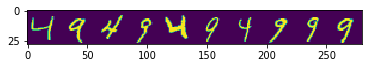

In [5]:
example_images = np.concatenate(images_4_9[:10], axis=1)
example_labels = labels_4_9[:10]
print(example_labels)
plt.imshow(example_images)
plt.grid(False)

Here we'll split our training set into 10000 for training and the rest for validation.

In [0]:
train_images, val_images = np.split(images_4_9, [10000])
train_labels, val_labels = np.split(labels_4_9, [10000])

In [7]:
print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)

(10000, 28, 28) (10000,)
(1791, 28, 28) (1791,)


And we'll normalize our data in one of the simplest ways possible: centering and scaling on an image-by-image basis.

In [0]:
def normalize_stats_image_by_image(images):
  mean = images.mean(axis=(1,2), keepdims=True)
  stdev = images.std(axis=(1,2), keepdims=True)
  return (images - mean) / stdev

In [0]:
train_images = normalize_stats_image_by_image(train_images)
val_images = normalize_stats_image_by_image(val_images)

In [10]:
print(train_images[:3].mean(axis=(1, 2)))
print(train_images[:3].std(axis=(1, 2)))
print(val_images[:3].mean(axis=(1, 2)))
print(val_images[:3].std(axis=(1, 2)))

[ 0.0000000e+00 -2.4328427e-08 -2.4328427e-08]
[1.        0.9999999 1.       ]
[ 4.8656852e-09 -1.4597056e-08 -1.4597056e-08]
[1.        1.        0.9999999]


Let's view some of the training and validation examples, all concatenated together so that they share the same color range (without any additional tweaking).

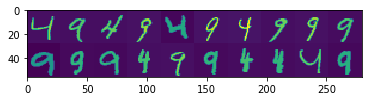

In [11]:
some_train_images = np.concatenate(train_images[:10], axis=1)
some_val_images = np.concatenate(val_images[:10], axis=1)
some_train_and_val_images = np.concatenate([some_train_images, some_val_images], axis=0)
plt.imshow(some_train_and_val_images)
plt.grid(False)

Let's also reshape all examples, under the assumption that *our models will always accept vectors rather than images.*

In [0]:
train_vectors = train_images.reshape(-1, HEIGHT * WIDTH)
val_vectors = val_images.reshape(-1, HEIGHT * WIDTH)

**Answer each of the following questions in the corresponding Markdown cells:**

**Look up the documentation for `torch.from_numpy`. What does it return?**

The torch.from_numpy method returns a `Tensor`.

**What does the `requires_grad` parameter of `Tensor` do ?** Hint: Take a look at https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

**Complete the following function, which retrieves a batch of examples.**

In [0]:
def batch(batch_size, training=True):
  """Create a batch of examples.
  
  This creates a batch of inputs and a batch of corresponding
  ground-truth labels.
  
  Args:
    batch_size: An integer.
    training: A boolean. If True, grab examples from the training
      set; otherwise, grab them from the validation set.
  
  Returns:
    A tuple,
    input_batch: A Tensor of floats with shape
      [batch_size, num_features]
    label_batch: A Tensor of ints with shape
      [batch_size].
  """
  if training:
    random_ind = np.random.choice(train_vectors.shape[0], size=batch_size, replace=False)
    input_batch = train_vectors[random_ind]
    label_batch = train_labels[random_ind]
  else:
    input_batch = val_vectors[:batch_size]
    label_batch = val_labels[:batch_size]
  
  # Create PyTorch Tensors from our NumPy arrays
  # TODO: Fill in each line.
  input_batch =  torch.tensor(input_batch, requires_grad=False)
  label_batch =  torch.tensor(label_batch, requires_grad=False)
  
  return input_batch, label_batch

**Answer each of the following questions in the corresponding Markdown cells:**

**What are the arguments for `torch.nn.Linear`? Describe each argument using a single sentence.** Hint: You can hit `tab` or you can search for `Linear` here: http://pytorch.org/docs/master/nn.html

The arguments to torch.nn.Linear function are:

`in_features`: which is the size of each input sample, where the intput is of shape `(N, *, in_features)`

`out_features`: which is the size of each output sample, where the output is of shape `(N, *, out_features)`

`bias`: This is a `boolean` flag, if set to False, the layer will not learn an additive bias, but it defaults to `True`


**Look at the example(s) for `Linear` in http://pytorch.org/docs/master/nn.html and answer: Why might it make sense to instantiate a `Linear` object that can later be called as a function?**

If we initialize the `Linear` object as a fucntion, we can then call it on any data, with a size of `in_features` for each sample, to be transformed to an output of size `out_features` for each sample.

**Complete the following model, which maps examples from a dimensionality of `HEIGHT * WIDTH` to a dimensionality of 1 through a linear (actually, affine) transformation.**

For any particular example $\xb$, we'll end up modeling $p(y \mid \xb)$ as

$$
\hat{p}(y = 0) = \sigma(\wb^T\xb + b), \qquad
\hat{p}(y = 1) = 1 - \hat{p}(y = 0)
$$

where here the label $y = 0$ specifies that our image is a 4, and the label $y = 1$ specifies that our image is a 9.

This model should compute $\wb^T\xb + b$.

Hint: If you feel lost, take a look at the first example in http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html ; the idea should help guide you to defining and using `Module`s from `torch.nn`.

In [0]:
class SimpleLinear(torch.nn.Module):
  """A simple linear model.
  
  Map from inputs of size [batch_size, num_features] to
  outputs of size [batch_size, 1].
  """
  
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(HEIGHT * WIDTH, 1)
  
  def forward(self, x):
    x = self.linear(x)
    return x

Now, let's instantiate our model, which *is an object that can also be called as a function.*

In [0]:
model = SimpleLinear()

**In the following code cell, copy over**

```
for p in model.parameters():
  print(p.size())
```

**and run it.**

In [16]:
for name, p in model.named_parameters():
  print(name, p.size())

linear.weight torch.Size([1, 784])
linear.bias torch.Size([1])


**Answer in the following Markdown cell: You should see two sizes here. (`size` in PyTorch is analagous to `shape` in NumPy.) Based on the sizes you see, what do these two `Parameters` correspond to?**

The first parameter of size, [1, 784] is the weight and the second parameter of size [1] is the bias.

Let's look at a few examples (and predictions) before we train:

[0.4  0.29 0.6  0.64 0.38 0.59 0.5  0.3  0.36 0.52]


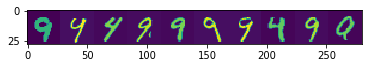

In [17]:
example_inputs, example_labels = batch(batch_size=10, training=True)
outputs = model(example_inputs)
label_1_probs = torch.sigmoid(outputs)

# Right now these are PyTorch Tensors. We can
# convert these Tensors to NumPy arrays using `numpy()`.
example_inputs, example_labels = example_inputs.numpy(), example_labels.numpy()
label_1_probs = label_1_probs.detach().cpu().numpy()

# Also, let's transform the inputs back into images for visualization.
example_images = example_inputs.reshape(-1, HEIGHT, WIDTH)
plt.imshow(np.concatenate(example_images, axis=1))
plt.grid(False)

print(label_1_probs.flatten().round(2))

**In the following Markdown cell, answer: Letting labels of 0 correspond to 4s and labels of 1 correspond to 9s, what fraction of the above probabilities would yield correct predictions?**

3 out of the above 10 proabilities will yield the correct preddctions

Let's create an optimizer, which keeps track of a particular set of parameters to optimizer over (here all of our model's parameters) and also takes steps according to some parameters (here just the learning rate).

In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

Now let's define functions to a) take one training step and b) perform one validation "step" (without optimization).

The loss for a *single* example is
$$
\begin{align}
l(\hat{\pb}, \pb)
&= -\sum_i p_i \log \hat{p}_i
\end{align}
$$

where

$$
\hat{p}_1 = \sigma(\wb^T\xb) \qquad \text{and} \qquad \hat{p}_0 = 1 - \hat{p}_1
$$

Note that `binary_cross_entropy_with_logits` expects *logits* as inputs (which have never been passed to the sigmoid) but *probabilities* as targets.

In [0]:
def train_step(batch_size=100):
  
  # This enables a `training` flag which differentiates operation
  # during training vs. operation during inference. Here we don't
  # need it, but it's good practice to set it.
  model.train()
  
  # Get a random training batch and compute corresponding outputs
  # from our model.
  input_batch, label_batch = batch(batch_size, training=True)
  output_batch = model(input_batch)
  
  # Compute loss (and error rate).
  # Note that our labels can be used as ground-truth probabilities,
  # but also note that binary_cross_entropy_with_logits expects
  # our outputs and ground-truth probabilities to have the same shape.
  p_batch = label_batch.float().view(-1, 1)
  loss = F.binary_cross_entropy_with_logits(output_batch, p_batch)  
  pred_batch = (output_batch > 0).view(-1).long()
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  
  # Here's the magic of backpropagation: calling backward fills
  # in the .grad attribute for all model parameters.
  optimizer.zero_grad()
  loss.backward()
  
  # Take a step.
  optimizer.step()
  
  return loss.item(), error_rate.item()

**In the following Markdown cell, answer: What would happen if we didn't reshape `p_batch` (using `view`) above?**

The outputs and ground-truth probabilities should have the same shape, the default shape of `label_batch` is [100], but after view it makes it a 2D matrix of size [[100, 1]], to match `output_batch`.

In [0]:
def val():
  
  model.eval()
  input_batch, label_batch = batch(len(val_vectors), training=False)
  output_batch = model(input_batch)

  p_batch = label_batch.float().view(-1, 1)
  loss = F.binary_cross_entropy_with_logits(output_batch, p_batch)  
  pred_batch = (output_batch > 0).view(-1).long()
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  
  return loss.item(), error_rate.item()

Finally, let's train, and also plot loss and error rate as a function of iteration.

Step     0: Obtained a best validation error of 0.662.
Step    50: Obtained a best validation error of 0.626.
Step   100: Obtained a best validation error of 0.588.
Step   150: Obtained a best validation error of 0.547.
Step   200: Obtained a best validation error of 0.502.
Step   250: Obtained a best validation error of 0.450.
Step   300: Obtained a best validation error of 0.404.
Step   350: Obtained a best validation error of 0.368.
Step   400: Obtained a best validation error of 0.331.
Step   450: Obtained a best validation error of 0.291.
Step   500: Obtained a best validation error of 0.259.
Step   550: Obtained a best validation error of 0.238.
Step   600: Obtained a best validation error of 0.222.
Step   650: Obtained a best validation error of 0.204.
Step   700: Obtained a best validation error of 0.192.
Step   750: Obtained a best validation error of 0.179.
Step   800: Obtained a best validation error of 0.168.
Step   850: Obtained a best validation error of 0.156.
Step   900

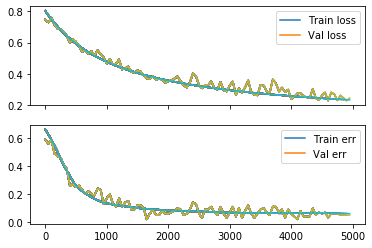

In [21]:
# Let's make sure we always start from scratch (that is,
# without starting from parameters from a previous run).
for module in model.children():
  module.reset_parameters()

info = []
fig, ax = plt.subplots(2, 1, sharex=True)
num_steps = 5000
num_steps_per_val = 50
best_val_err = 1.0
for step in range(num_steps):
  train_loss, train_err = train_step()
  if step % num_steps_per_val == 0:
    val_loss, val_err = val()
    if val_err < best_val_err:
      best_val_err = val_err
      print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
    info.append([step, train_loss, val_loss, train_err, val_err])
    x, y11, y12, y21, y22 = zip(*info)
    ax[0].plot(x, y11, x, y12)
    ax[0].legend(['Train loss', 'Val loss'])
    ax[1].plot(x, y21, x, y22)
    ax[1].legend(['Train err', 'Val err'])

[0.92 0.91 0.09 0.09 0.77 0.27 0.84 0.11 0.22 0.06]


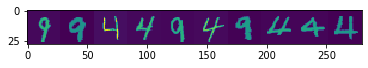

In [22]:
example_inputs, example_labels = batch(batch_size=10, training=True)
outputs = model(example_inputs)
label_1_probs = torch.sigmoid(outputs)

# Right now these are PyTorch Tensors. We can
# convert these Tensors to NumPy arrays using `numpy()`.
example_inputs, example_labels = example_inputs.numpy(), example_labels.numpy()
label_1_probs = label_1_probs.detach().cpu().numpy()

# Also, let's transform the inputs back into images for visualization.
example_images = example_inputs.reshape(-1, HEIGHT, WIDTH)
plt.imshow(np.concatenate(example_images, axis=1))
plt.grid(False)

print(label_1_probs.flatten().round(2))

**In the following Markdown cell, answer: Letting labels of 0 correspond to 4s and labels of 1 correspond to 9s, what fraction of the above probabilities would yield correct predictions?**

9 on 10 of the above probabilities yield correct predictions.

**In the following Markdown Cell, answer:**

**We took 5000 optimization steps, each with a batch size of 100 and a learning rate of 1e-4. Did the validation loss stabilize? What was the best validation error rate that you achieved?**

No the validation loss still keeps decreasing, it has not stabilized. At this stage the best validation error rate is: **5.8%**

Step     0: Obtained a best validation error of 0.480.
Step    50: Obtained a best validation error of 0.036.
Step   100: Obtained a best validation error of 0.032.
Step   150: Obtained a best validation error of 0.031.
Step   200: Obtained a best validation error of 0.028.
Step   450: Obtained a best validation error of 0.027.
Step   900: Obtained a best validation error of 0.026.
Step  4900: Obtained a best validation error of 0.025.


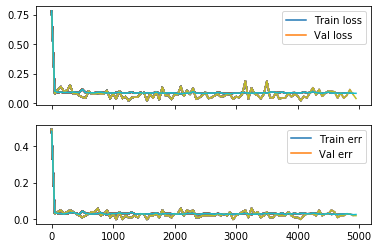

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
for module in model.children():
  module.reset_parameters()

info = []
fig, ax = plt.subplots(2, 1, sharex=True)
num_steps = 5000
num_steps_per_val = 50
best_val_err = 1.0
for step in range(num_steps):
  train_loss, train_err = train_step()
  if step % num_steps_per_val == 0:
    val_loss, val_err = val()
    if val_err < best_val_err:
      best_val_err = val_err
      print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
    info.append([step, train_loss, val_loss, train_err, val_err])
    x, y11, y12, y21, y22 = zip(*info)
    ax[0].plot(x, y11, x, y12)
    ax[0].legend(['Train loss', 'Val loss'])
    ax[1].plot(x, y21, x, y22)
    ax[1].legend(['Train err', 'Val err'])

**Rerun the above experiment with various learning rates to minimize the error rate on the validation set. What was the best error rate you could achieve?**

Hint: You should be able to hit an error rate of 3.5% or better.

With a learning rate of `0.1`, I got an error rate of 2.5%

**Write code to visualize the weight matrix of your best model as a 28 x 28 image.**

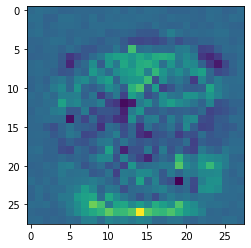

In [25]:
for name, p in model.named_parameters():
  if name == "linear.weight":
    plt.imshow(p.detach().numpy().reshape(HEIGHT, WIDTH))
  

**In the following Markdown Cell, answer:**

**Can you explain what you're seeing in this visualization of our weights? For example, what do you think the weights with large values (black in the image) correspond to?**

The weights with large values, which corresponds to the black pixels in the image correspond to the upper and lower curves in the number 9. So, when the model sees a 9, these large weights ensure that the prediction near 1.0, which is the class label of 9.

**Repeat the above experiments using a multilayer perceptron with 50 hidden units, using ReLU nonlinearities. Vary your learning rate as you wish to minimize the error rate on the validation set. What was the best error rate you were able to achieve?**

Note that **you do not need to reanswer questions and you do not need to repeat visualizations.** You just need to implement the MLP model, run training (potentially for various learning rates), and report your results. Hint: You should be able to hit an error rate on the validation set that's lower than 2%.

Note that this last exercise is *extremely simple*. All you need to do is a) create a SimpleMLP `Module` and instantiate that instead of `SimpleLinear`. The rest of your code should require nearly no changes at all (except for e.g. varying the learning rate).

In [0]:
class SimpleMLP(torch.nn.Module):
  """A simple MLP model."""
  
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(HEIGHT * WIDTH, 50)
    self.linear2 = torch.nn.Linear(50, 1)
  
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    return x
  
model = SimpleMLP()

In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)

Step     0: Obtained a best validation error of 0.490.
Step    50: Obtained a best validation error of 0.046.
Step   100: Obtained a best validation error of 0.035.
Step   150: Obtained a best validation error of 0.030.
Step   200: Obtained a best validation error of 0.023.
Step   400: Obtained a best validation error of 0.022.
Step   450: Obtained a best validation error of 0.020.
Step   500: Obtained a best validation error of 0.020.
Step   800: Obtained a best validation error of 0.019.
Step  1800: Obtained a best validation error of 0.018.


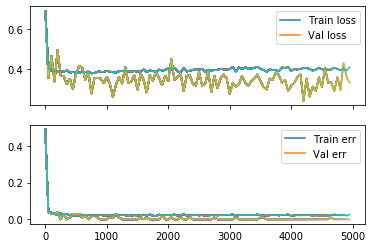

In [33]:
for module in model.children():
  module.reset_parameters()

info = []
fig, ax = plt.subplots(2, 1, sharex=True)
num_steps = 5000
num_steps_per_val = 50
best_val_err = 1.0
for step in range(num_steps):
  train_loss, train_err = train_step()
  if step % num_steps_per_val == 0:
    val_loss, val_err = val()
    if val_err < best_val_err:
      best_val_err = val_err
      print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
    info.append([step, train_loss, val_loss, train_err, val_err])
    x, y11, y12, y21, y22 = zip(*info)
    ax[0].plot(x, y11, x, y12)
    ax[0].legend(['Train loss', 'Val loss'])
    ax[1].plot(x, y21, x, y22)
    ax[1].legend(['Train err', 'Val err'])

The SimpleMLP model defined above, with a **learning rate of `0.3`**, achieves a best validation error rate of **1.5%**. But the model seems to very slightly starting to overfit the training data!